In [28]:
import os                        
from collections import Counter  
from pprint import pprint

import pandas as pd              
import numpy as np               
import pymatgen         

In [29]:
import matplotlib                
import matplotlib.pyplot as plt
import seaborn as sns            

In [30]:
import sklearn                   
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate,GridSearchCV,ParameterGrid
from sklearn.model_selection import KFold,RepeatedKFold

In [31]:
import graphviz                  

In [32]:
from helper_functions import *

In [33]:
seed = 2345312

In [34]:
# Read in band gap data from our dataset
mastml_df = pd.read_csv("../data/bandgap_data_v2.csv")

In [35]:
mastml_df

,index,chemicalFormula Clean,Band gap values Clean,Band gap units,Band gap method,Reliability
0,0,Li1F1,13.60,eV,Reflection,1
1,1,Li1F1,12.61,eV,Reflection,1
2,2,Li1F1,12.60,eV,Estimated,2
3,3,Li1F1,12.10,eV,Absorption,2
4,4,Li1F1,12.00,eV,Absorption,2
...,...,...,...,...,...,...
1442,1454,Th1O2,3.30,eV,Reflection,2
1443,1455,UO,1.50,eV,Thermal activation,1
1444,1456,U1O2,2.18,eV,Absorption,1
1445,1457,UO,0.60,eV,Thermal activation,2


In [36]:
# Filter for only Reliability 1
mastml_df_filtered = mastml_df[mastml_df["Reliability"]==1]

In [37]:
# Print the filtered data
mastml_df_filtered

,index,chemicalFormula Clean,Band gap values Clean,Band gap units,Band gap method,Reliability
0,0,Li1F1,13.600,eV,Reflection,1
1,1,Li1F1,12.610,eV,Reflection,1
6,6,Li1Cl1,9.330,eV,Reflection,1
7,7,Li1Br1,7.950,eV,Absorption,1
9,9,Li3Sb1,1.000,eV,Thermal activation,1
...,...,...,...,...,...,...
1433,1445,Bi,0.015,eV,Magnetoreflection,1
1436,1448,Th1O2,5.750,eV,NaN,1
1437,1449,Th1O2,3.500,eV,Absorption,1
1443,1455,UO,1.500,eV,Thermal activation,1


In [38]:
mastml_df_clean = mastml_df_filtered.groupby("chemicalFormula Clean", as_index = False).mean()

mastml_df_clean

,chemicalFormula Clean,index,Band gap values Clean,Reliability
0,Ag1Br1,808.5,3.485,1.0
1,Ag1Cl1,793.5,4.190,1.0
2,Ag1N3,783.0,3.900,1.0
3,Ag1Te1,820.0,0.850,1.0
4,Ag2O1,785.0,1.200,1.0
...,...,...,...,...
462,Zr1Se2,739.0,2.000,1.0
463,Zr1Se3,740.0,1.250,1.0
464,Zr3O1,730.0,0.200,1.0
465,Zr6O1,729.0,0.180,1.0


In [39]:
# generate statistics based on band gap values
mastml_df_clean["Band gap values Clean"].describe().round(3)

count    467.000
mean       2.231
std        2.287
min        0.009
25%        0.695
50%        1.435
75%        3.000
max       13.105
Name: Band gap values Clean, dtype: float64

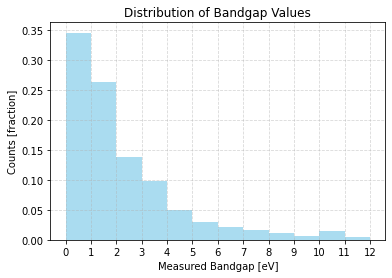

In [49]:
def histogram_plot(data, xlabel='Measured Bandgap [eV]', ylabel='Counts [fraction]', bins=range(13), density=True, color='skyblue', alpha=0.7):
    fig1, ax1 = plt.subplots()
    ax1.hist(data, bins=bins, density=density, color=color, alpha=alpha)
    ax1.set_xticks(range(13))
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.5)  # Add grid lines
    plt.title('Distribution of Bandgap Values')  # Add title
    plt.show()

histogram_plot(mastml_df_clean["Band gap values Clean"].astype("float"))

In [50]:
# parse out individual elements for each formula using pymatgen's composition parser
element_list = list()
for idx in mastml_df.index:
    element_list.extend(pymatgen.core.composition.Composition(mastml_df["chemicalFormula Clean"][idx]).elements)

In [51]:
# setup a counter to count each element
temp_counter = Counter(element_list)
element_tuples = list(zip(list(temp_counter.keys()),list(temp_counter.values())))
element_df = pd.DataFrame(element_tuples,columns=["Element","Count"])
element_df_sorted = element_df.sort_values(by=["Count"],ascending=False)

In [52]:
element_df_sorted

,Element,Count
8,O,240
10,Se,196
9,S,191
11,Te,187
15,As,141
...,...,...
66,Ta,3
39,Y,3
70,Ir,2
62,Tm,1


In [44]:
# Output data to csv
output_path = "../data/bandgap_data_v3.csv"

if os.path.isfile(output_path):
    print(output_path," It already exists, not creating new file")
else:
    mastml_df_clean.to_csv(output_path)

../data/bandgap_data_v3.csv  exists, not creating new file


In [45]:
# new dataframe of generated features
cwd = os.getcwd()
generated_features_path = os.path.join(cwd,"./generated_features/generated_features.csv")
features_df = pd.read_csv(generated_features_path)

In [46]:
#split features_df into two dataframes
target_data_df = pd.DataFrame([features_df["chemicalFormula Clean"],features_df["Band gap values Clean"],features_df["Band gap units"],features_df["index"],features_df["Reliability"]]).T
features_df = features_df.drop(columns=['index','Reliability','Band gap values Clean','Band gap units','chemicalFormula Clean'])

In [47]:
target_data_df # our original dataset with inputs and outputs

,chemicalFormula Clean,Band gap values Clean,Band gap units,index,Reliability
0,Li1F1,13.105,eV,0,1
1,Li1Cl1,9.33,eV,6,1
2,Li1Br1,7.95,eV,7,1
3,Li3Sb1,1,eV,9,1
4,Li1I1,6,eV,10,1
...,...,...,...,...,...
462,Bi1I3,1.9625,eV,1437,1
463,Bi,0.015,eV,1445,1
464,Th1O2,4.625,eV,1448,1
465,UO,1.5,eV,1455,1


In [21]:
features_df # features generated

,AtomicNumber_composition_average,AtomicRadii_composition_average,AtomicVolume_composition_average,AtomicWeight_composition_average,BCCefflatcnt_composition_average,BCCenergy_pa_composition_average,BCCfermi_composition_average,BCCmagmom_composition_average,BCCvolume_pa_composition_average,BCCvolume_padiff_composition_average,...,SecondIonizationEnergy_composition_average,ShearModulus_composition_average,SpaceGroupNumber_composition_average,SpecificHeatCapacity_composition_average,ThermalConductivity_composition_average,ThermalExpansionCoefficient_composition_average,ThirdIonizationEnergy_composition_average,n_ws^third_composition_average,phi_composition_average,valence_composition_average
0,6.000000,1.135000,9311.576313,12.969702,5.772386,-1.346741,-0.679877,0.0,12.4700,-0.680417,...,55.804000,2.100000,122.00,2.203000,42.363950,923.000000,92.579000,0.490000,1.4250,1.000000
1,10.000000,1.270000,9169.525548,21.197000,6.658641,-1.410040,1.219961,0.0,18.5250,-2.020417,...,50.224000,2.100000,146.50,2.031000,42.354450,23.000000,81.031000,0.490000,1.4250,4.000000
2,19.000000,1.345000,32.035942,43.422500,6.919518,-1.432083,1.117212,0.0,21.0350,-2.001667,...,49.219000,2.100000,146.50,1.904000,42.411000,23.000000,79.225500,0.490000,1.4250,4.000000
3,15.000000,1.560000,23.705899,35.645750,6.704252,-2.371630,2.267697,0.0,19.1550,-1.180000,...,61.611000,8.150000,213.25,2.738250,69.600000,37.250000,98.163250,1.050000,3.2375,2.000000
4,28.000000,1.440000,32.101458,66.922735,7.343549,-1.459519,2.360221,0.0,25.9350,-3.869167,...,47.884500,2.100000,146.50,1.863500,42.574500,66.500000,77.725500,0.490000,1.4250,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,60.500000,1.422500,40.865008,147.423452,8.158525,-1.763974,5.485714,0.0,33.9975,-6.501250,...,18.520000,3.000000,51.00,0.139250,2.304250,68.600000,31.139750,0.290000,1.0375,6.500000
463,83.000000,1.700000,35.483459,208.980400,7.821898,-3.895384,8.463157,0.0,29.9100,-3.040000,...,16.687000,12.000000,12.00,0.122000,7.870000,13.400000,25.559000,1.160000,4.1500,5.000000
464,35.333333,1.086000,12405.753339,88.012287,5.956046,-4.062017,4.524067,0.0,15.8700,-0.990000,...,27.246000,10.333333,83.00,0.651000,18.178267,523.666667,43.290333,0.426667,1.1000,2.666667
465,50.000000,1.057500,9306.473007,127.014155,5.880448,-6.738583,8.971338,0.0,13.7800,-0.785000,...,17.558500,55.500000,37.50,0.520000,13.933700,396.950000,27.467000,0.755000,1.9500,4.000000


In [22]:
# Remove Constant Columns
features_df_noconstant = features_df.loc[:, (features_df != features_df.iloc[0]).any()] 

# report columns
len(features_df_noconstant.columns)

86

In [23]:
# Remove Highly correlated Features
# using notes here for methodology: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

features_corr_df = features_df_noconstant.corr(method="pearson").abs()
features_corr_df.iloc[:5, :5] # Preview the first 5 rows/columns of the correlation matrix

,AtomicNumber_composition_average,AtomicRadii_composition_average,AtomicVolume_composition_average,AtomicWeight_composition_average,BCCefflatcnt_composition_average
AtomicNumber_composition_average,1.000000,0.585580,0.405061,0.998598,0.628049
AtomicRadii_composition_average,0.585580,1.000000,0.609457,0.571820,0.918506
AtomicVolume_composition_average,0.405061,0.609457,1.000000,0.382296,0.449378
AtomicWeight_composition_average,0.998598,0.571820,0.382296,1.000000,0.615523
BCCefflatcnt_composition_average,0.628049,0.918506,0.449378,0.615523,1.000000


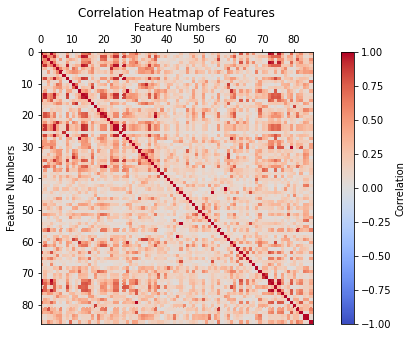

In [48]:
# before removing correlated features
fig1, ax1 = plt.subplots(figsize=(10,5))
c = ax1.pcolor(features_corr_df, cmap="coolwarm", vmin=-1, vmax=1)  # Change colormap to coolwarm and set vmin and vmax for better contrast
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Feature Numbers')
ax1.set_ylabel('Feature Numbers')
ax1.set_aspect('equal')
plt.colorbar(c, ax=ax1, label='Correlation')  # Add label to colorbar
plt.title('Correlation Heatmap of Features')  # Add title to the plot
plt.show()


In [53]:
# Filter the features with correlation coefficients above 0.95
mask = np.triu(np.ones(features_corr_df.shape), k=1).astype(bool)  # Create a mask for upper triangular matrix
upper_tri = features_corr_df.where(mask)
highly_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
features_df_lowcorr = features_df_noconstant.drop(columns=highly_corr_features)

# Recalculate the correlation matrix after feature removal
features_corr_df_update = features_df_lowcorr.corr(method="pearson").abs()

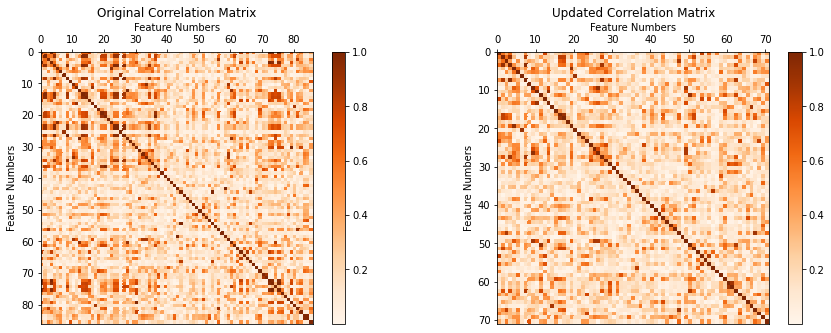

In [57]:
# Plot correlation after removing highly correlated features
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot original correlation matrix
cmap = "Oranges"
ax1 = axes[0]
heatmap1 = ax1.pcolor(features_corr_df, cmap=cmap)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Feature Numbers')
ax1.set_ylabel('Feature Numbers')
ax1.set_aspect('equal')
ax1.set_title('Original Correlation Matrix')
plt.colorbar(heatmap1, ax=ax1)

# Plot updated correlation matrix after removing highly correlated features
ax2 = axes[1]
heatmap2 = ax2.pcolor(features_corr_df_update, cmap=cmap)
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Feature Numbers')
ax2.set_ylabel('Feature Numbers')
ax2.set_aspect('equal')
ax2.set_title('Updated Correlation Matrix')
plt.colorbar(heatmap2, ax=ax2)

plt.show()

In [58]:
len(features_df_lowcorr.columns)

71

In [59]:
features_df_lowcorr

,AtomicNumber_composition_average,AtomicRadii_composition_average,AtomicVolume_composition_average,BCCefflatcnt_composition_average,BCCenergy_pa_composition_average,BCCfermi_composition_average,BCCmagmom_composition_average,BCCvolume_pa_composition_average,BCCvolume_padiff_composition_average,BoilingT_composition_average,...,NsValence_composition_average,Polarizability_composition_average,SecondIonizationEnergy_composition_average,ShearModulus_composition_average,SpaceGroupNumber_composition_average,ThermalConductivity_composition_average,ThermalExpansionCoefficient_composition_average,ThirdIonizationEnergy_composition_average,n_ws^third_composition_average,valence_composition_average
0,6.000000,1.135000,9311.576313,5.772386,-1.346741,-0.679877,0.0,12.4700,-0.680417,849.940000,...,1.50,12.446000,55.804000,2.100000,122.00,42.363950,923.000000,92.579000,0.490000,1.000000
1,10.000000,1.270000,9169.525548,6.658641,-1.410040,1.219961,0.0,18.5250,-2.020417,926.980000,...,1.50,13.257500,50.224000,2.100000,146.50,42.354450,23.000000,81.031000,0.490000,4.000000
2,19.000000,1.345000,32.035942,6.919518,-1.432083,1.117212,0.0,21.0350,-2.001667,973.500000,...,1.50,13.692500,49.219000,2.100000,146.50,42.411000,23.000000,79.225500,0.490000,4.000000
3,15.000000,1.560000,23.705899,6.704252,-2.371630,2.267697,0.0,19.1550,-1.180000,1676.250000,...,1.25,19.901250,61.611000,8.150000,213.25,69.600000,37.250000,98.163250,1.050000,2.000000
4,28.000000,1.440000,32.101458,7.343549,-1.459519,2.360221,0.0,25.9350,-3.869167,1036.150000,...,1.50,14.680000,47.884500,2.100000,146.50,42.574500,66.500000,77.725500,0.490000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,60.500000,1.422500,40.865008,8.158525,-1.763974,5.485714,0.0,33.9975,-6.501250,802.225000,...,2.00,3.868750,18.520000,3.000000,51.00,2.304250,68.600000,31.139750,0.290000,6.500000
463,83.000000,1.700000,35.483459,7.821898,-3.895384,8.463157,0.0,29.9100,-3.040000,1837.000000,...,2.00,0.400000,16.687000,12.000000,12.00,7.870000,13.400000,25.559000,1.160000,5.000000
464,35.333333,1.086000,12405.753339,5.956046,-4.062017,4.524067,0.0,15.8700,-0.990000,1757.733333,...,2.00,11.234667,27.246000,10.333333,83.00,18.178267,523.666667,43.290333,0.426667,2.666667
465,50.000000,1.057500,9306.473007,5.880448,-6.738583,8.971338,0.0,13.7800,-0.785000,2145.050000,...,2.00,12.851000,17.558500,55.500000,37.50,13.933700,396.950000,27.467000,0.755000,4.000000


In [60]:
minmax_features = MinMaxScaler().fit_transform(features_df_lowcorr)
minmax_features_df = pd.DataFrame(minmax_features,columns=features_df_lowcorr.columns)
minmax_features_df.iloc[:5, :5]

,AtomicNumber_composition_average,AtomicRadii_composition_average,AtomicVolume_composition_average,BCCefflatcnt_composition_average,BCCenergy_pa_composition_average
0,0.012821,0.190923,0.583946,0.176111,0.893262
1,0.064103,0.275430,0.575030,0.310002,0.884705
2,0.179487,0.322379,0.001553,0.349415,0.881725
3,0.128205,0.456964,0.001030,0.316893,0.754709
4,0.294872,0.381847,0.001557,0.413475,0.878016


In [61]:
X = minmax_features_df                         # inputs/features 
y = target_data_df["Band gap values Clean"] # outputs/targets

In [62]:
# Find prediction compounds and generate inputs for them to make predictions later.
def extract_predictions(formula="string"):
    index_prediction = target_data_df[target_data_df["chemicalFormula Clean"]==formula].index
    xpredict = X.loc[index_prediction].copy()
    ypredict = y.loc[index_prediction]
    
    return (index_prediction,xpredict,ypredict)

In [63]:
index_predict_Si, xpredict_Si, ypredict_Si = extract_predictions(formula="Si")
index_predict_SiO2, xpredict_SiO2, ypredict_SiO2 = extract_predictions(formula="Si1O2")
index_predict_C, xpredict_C, ypredict_C = extract_predictions(formula="C")
index_predict_Sn, xpredict_Sn, ypredict_Sn = extract_predictions(formula="Sn")
index_predict_NaCl, xpredict_NaCl, ypredict_NaCl = extract_predictions(formula="Na1Cl1")

X_predict = X.drop(index=index_predict_Si.to_list()+index_predict_SiO2.to_list()+index_predict_C.to_list()+index_predict_Sn.to_list()+index_predict_NaCl.to_list())
y_predict = y.drop(index=index_predict_Si.to_list()+index_predict_SiO2.to_list()+index_predict_C.to_list()+index_predict_Sn.to_list()+index_predict_NaCl.to_list())

In [64]:
test_fraction = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_fraction, shuffle=True, random_state=seed)

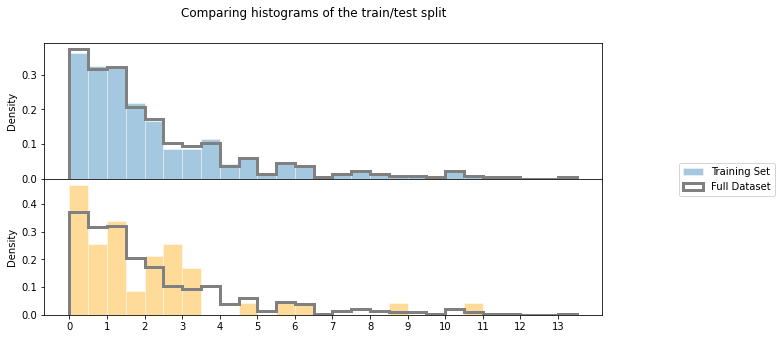

In [66]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 5), sharex=True, gridspec_kw={'hspace': 0})
myarray = mastml_df_clean["Band gap values Clean"]

bins = np.true_divide(range(28), 2)

# Plot histograms for training and test sets
sns.distplot(y_train.astype("float"), hist=True, norm_hist=True, kde=False, bins=bins, hist_kws={"edgecolor": "white"}, label='Training Set', ax=ax1)
sns.distplot(y_test.astype("float"), hist=True, norm_hist=True, kde=False, bins=bins, hist_kws={"edgecolor": "white", "color": "orange"}, label='Test Set', ax=ax2)

# Plot histogram for the full dataset
sns.distplot(myarray, hist=True, norm_hist=True, kde=False, bins=bins, hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "grey"}, label='Full Dataset', ax=ax1)
sns.distplot(myarray, hist=True, norm_hist=True, kde=False, bins=bins, hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "grey"}, label='Full Dataset', ax=ax2)

# Set x-axis ticks
ax1.set_xticks(range(14))
ax2.set_xticks(range(14))

# Hide x-axis label on the second subplot
ax2.xaxis.label.set_visible(False)

# Add legends
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 10})

# Set titles and axis labels
fig.suptitle('Comparing histograms of the train/test split')
plt.xlabel('Measured Bandgap (eV)')
ax1.set_ylabel('Density')
ax2.set_ylabel('Density')

plt.show()

In [68]:
Default_model = RandomForestRegressor(random_state=seed,n_estimators=1,bootstrap=False).fit(X_train,y_train) # fit the decision tree model
print('Model training complete.')
# print('Tree depth:', [estimator.tree_.max_depth for estimator in Default_model.estimators_])
# for importance in zip (estimator.feature_importances_ for estimator in Default_model.estimators_):
#     print (importance)
#print('Leaf nodes:',[estimator.tree_.n_leaves for estimator in Default_model.estimators_])

Model training complete.


In [71]:
Default_model_all_data = RandomForestRegressor(random_state=seed,n_estimators=1,bootstrap=False).fit(X_predict,y_predict)

print("Predicting Silicon Band Gap: ",Default_model_all_data.predict(xpredict_Si))

print("Predicting Silica Band Gap: ",Default_model_all_data.predict(xpredict_SiO2))

Predicting Silicon Band Gap:  [2.]
Predicting Silica Band Gap:  [7.]


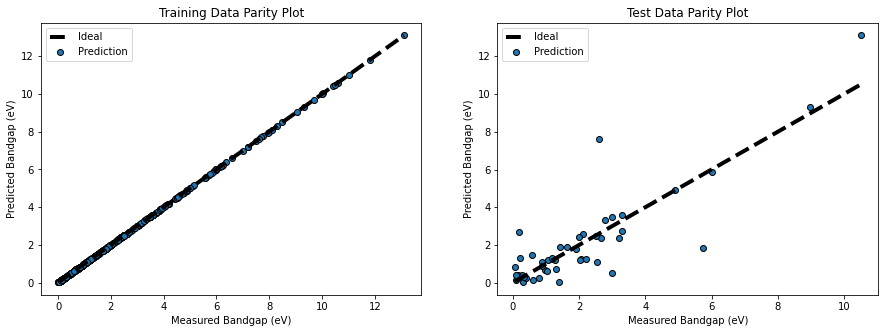

,Error Metric,Training Data,Test Data,Note
0,RMSE,0.0003 (eV),1.2398 (eV),(0.0 for perfect prediction)
1,RMSE/std,0.0001,0.5771,(0.0 for perfect prediction)
2,MAE,0.0 (eV),0.723 (eV),(0.0 for perfect prediction)
3,R2,1,0.6669,(1.0 for perfect prediction)


In [72]:
Train_predictions = Default_model.predict(X_train)    # Make predictions on training data
Test_predictions = Default_model.predict(X_test)      # Make predictions on testing data

parity_plots_side_by_side(y_train,Train_predictions,y_test,Test_predictions,title_left="Training Data Parity Plot",title_right="Test Data Parity Plot") # build both plots
parity_stats_side_by_side(y_train,Train_predictions,y_test,Test_predictions,"Training Data","Test Data")  # print error metrics for training data

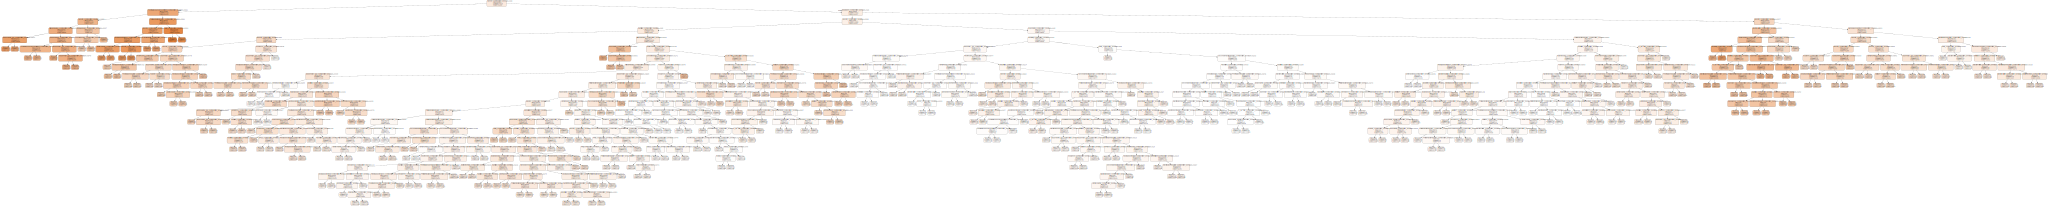

In [73]:
# generate an image of the default decision tree
dot_data = sklearn.tree.export_graphviz(Default_model.estimators_[0],out_file=None,feature_names=features_df_lowcorr.columns,filled=True,rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [74]:
print('Default model uses the following hyperparameters:\n') # print default hyperparameters used
pprint(Default_model.get_params())

Default model uses the following hyperparameters:

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2345312,
 'verbose': 0,
 'warm_start': False}


In [75]:
# set up hyperparameter grid (a dictionary of hyperparameter candidates that we want the optimization strategy to consider)

number_of_trees = [1,10,35,50,65,80,105,120,135,150]

opt_dict = {'n_estimators':number_of_trees,'bootstrap':['True']}

In [76]:
# kfold = KFold(n_splits=10,random_state=seed,shuffle=True)
kfold = RepeatedKFold(n_splits=10,
                      random_state=seed,
                      n_repeats=10)

In [85]:
# define a grid search strategy

import time

CV = GridSearchCV(Default_model, # 1. the model whose hyperparamter is being optimized right now
                  opt_dict,   # 2. a dictionary of values that we want the grid search to use
                  cv=kfold,   # 4. k-fold cross-validation strategy is used to define training and validation splits (note this is separate from test splits) to be used for each grid point
                  return_train_score=True,
                  scoring=['neg_mean_squared_error','r2','neg_mean_absolute_error'], # 5. the performance metrics to be reported at each grid point specified in opt_dict
                  refit='neg_mean_squared_error')

# perform grid search
tic = time.perf_counter() # start timer

CV = CV.fit(X_train,y_train)

toc = time.perf_counter() # stop timer

# print results
print(f"Grid search completed in {toc - tic:0.3f} seconds.")
print(CV.best_params_)

Grid search completed in 758.460 seconds.
{'bootstrap': 'True', 'n_estimators': 120}


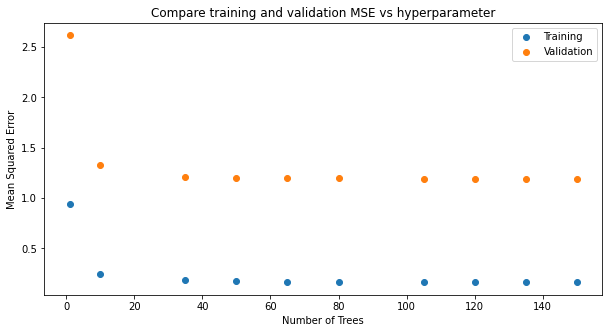

Minimum Mean Squared Error:  1.189
Number of Trees at minimum:  120


In [86]:
# plot number of trees vs train and test MSE

opt_dict_array = opt_dict["n_estimators"]                     # array of grid points (x-axis)
train_mse = CV.cv_results_["mean_train_neg_mean_squared_error"] # MSE of training set at each grid point (y-axis)
test_mse = CV.cv_results_["mean_test_neg_mean_squared_error"]   # MSE of test set at each grid point (y-axis)

fig1,ax1 = plt.subplots(figsize=(10,5))
ax1.scatter(opt_dict_array, -train_mse)
ax1.scatter(opt_dict_array, -test_mse)
# ax1.fill_between(opt_dict_array, -train_mse, -test_mse, alpha=0.1)
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Compare training and validation MSE vs hyperparameter')
plt.legend(["Training","Validation","difference"])
plt.show()
print("Minimum Mean Squared Error: ", round(min(-test_mse),4))
print("Number of Trees at minimum: ", opt_dict_array[np.argmin(-test_mse)])

In [87]:
# check what the best parameters identified in the grid search were
CV.best_params_

{'bootstrap': 'True', 'n_estimators': 120}

In [88]:
# Extract cross validation performance metrics for the optimized model
opt_CV_stats = CV_best_stats(CV,y_train)

Average test RMSE:  1.0904 (0.0 for perfect prediction)
Average test RMSE/std:  0.4745 (0.0 for perfect prediction)
Average test MAE:  0.7368 (0.0 for perfect prediction)
Average test R2:  0.7518 (1.0 for perfect prediction)


In [89]:
default_opt_dict = {'n_estimators':[1]}

default_CV = GridSearchCV(Default_model,
                          default_opt_dict,
                          cv=kfold,
                          return_train_score=True,
                          scoring=['neg_mean_squared_error','r2','neg_mean_absolute_error'],
                          refit='neg_mean_squared_error')
default_CV = default_CV.fit(X_train,y_train)

default_CV_stats = CV_best_stats(default_CV,y_train)

Average test RMSE:  1.4457 (0.0 for perfect prediction)
Average test RMSE/std:  0.6291 (0.0 for perfect prediction)
Average test MAE:  0.9655 (0.0 for perfect prediction)
Average test R2:  0.5487 (1.0 for perfect prediction)


In [90]:
# Refit the model using the best hyperparameters
DT2 = CV.best_estimator_.fit(X_train,y_train)

# predict both the train and test data
Train_predictions2 = DT2.predict(X_train)
Test_predictions2 = DT2.predict(X_test)

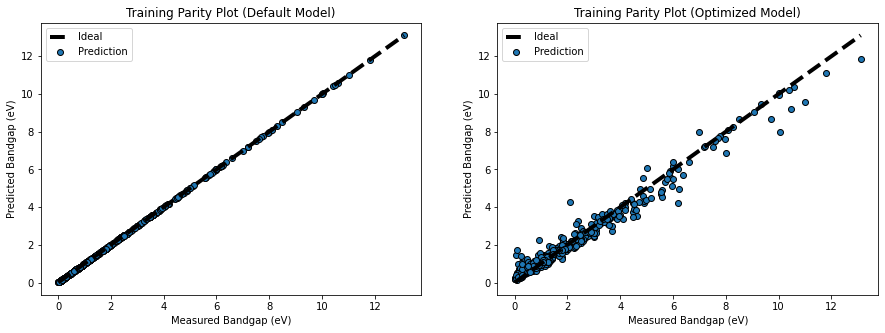

,Error Metric,Training Set (Default Model),Training Set (Optimized Model),Note
0,RMSE,0.0003 (eV),0.4112 (eV),(0.0 for perfect prediction)
1,RMSE/std,0.0001,0.1789,(0.0 for perfect prediction)
2,MAE,0.0 (eV),0.2681 (eV),(0.0 for perfect prediction)
3,R2,1,0.968,(1.0 for perfect prediction)


In [91]:
parity_plots_side_by_side(y_train,Train_predictions,y_train,Train_predictions2,title_left="Training Parity Plot (Default Model)",title_right="Training Parity Plot (Optimized Model)") # build both plots
parity_stats_side_by_side(y_train,Train_predictions,y_train,Train_predictions2,"Training Set (Default Model)","Training Set (Optimized Model)")

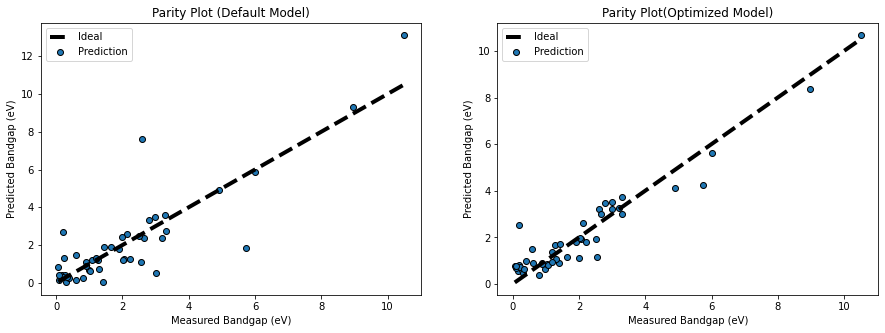

,Error Metric,Test Set (Default Model),Test Set (Optimized Model),Note
0,RMSE,1.2398 (eV),0.6307 (eV),(0.0 for perfect prediction)
1,RMSE/std,0.5771,0.2936,(0.0 for perfect prediction)
2,MAE,0.723 (eV),0.4808 (eV),(0.0 for perfect prediction)
3,R2,0.6669,0.9138,(1.0 for perfect prediction)


In [97]:
parity_plots_side_by_side(y_test,Test_predictions,y_test,Test_predictions2, title_left="Parity Plot (Default Model)",title_right="Parity Plot(Optimized Model)") # build both plots
parity_stats_side_by_side(y_test,Test_predictions,y_test,Test_predictions2,"Test Set (Default Model)","Test Set (Optimized Model)")

In [98]:
# fit model to all data except for the values we want to predict.
DT3 = CV.best_estimator_.fit(X_predict,y_predict)

In [99]:
Prediction_features = xpredict_Si

# prediction with the trained DT3 model
print("Predicted Band Gap: ",DT3.predict(Prediction_features))

Predicted Band Gap:  [1.55400833]


In [100]:
# combine previous data into one dataframe for visualization
predictions_combined = pd.DataFrame(list(zip(y_test,Test_predictions2)),columns=['test','predictions'])

In [101]:
# sort on the Test values from low to high
predictions_combined.sort_values("test")

,test,predictions
31,0.064,0.768092
39,0.100,0.782275
10,0.100,0.699438
0,0.170,0.540383
21,0.200,2.538822
20,0.200,0.799863
37,0.230,0.727042
7,0.270,0.617367
9,0.310,0.458133
43,0.332,0.620600
